In [26]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/nfl')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Get detection result

In [ ]:
# all parmas can change
video_path = 'data/test/'
best_w = 'model/yolov5m-30/exp/weights/best.pt' 
video_frame_path = 'data/mp4_image_test/'
yolov5_path = 'myYolov5_2/'
detection_result_df_path = 'test_detection.csv'

In [ ]:
# Download YOLOv5
!git clone https://github.com/yuyang0828/yolov5.git myYolov5_2 # clone repo
%cd myYolov5_2
# Install dependencies
%pip install -qr requirements.txt  # install dependencies

%cd ../

Cloning into 'myYolov5_2'...
remote: Enumerating objects: 9878, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 9878 (delta 0), reused 0 (delta 0), pack-reused 9875
Receiving objects: 100% (9878/9878), 10.07 MiB | 6.51 MiB/s, done.
Resolving deltas: 100% (6870/6870), done.
/content/gdrive/My Drive/nfl/myYolov5_2
/content/gdrive/My Drive/nfl


In [ ]:
import torch
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.9.0+cu111 (Tesla K80)


In [ ]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.core.display import Video, display
import subprocess

In [ ]:
for video_name in os.listdir(video_path):
  ex_video = video_path + video_name

  video_name = video_name.replace('.mp4', '')
  frame_dir = video_frame_path + video_name
  img_ext = 'jpg'
  image_name = video_name
  
  
  os.makedirs(frame_dir, exist_ok=True)
  cmd = 'ffmpeg -i \"{}\" -qscale:v 2 \"{}/{}_%d.{}\"'.format(ex_video, frame_dir, image_name, img_ext)
  print(cmd)
  subprocess.call(cmd, shell=True)

  IMG_S=720
  project_name = video_name
  cmd2 = 'python {}detect.py --weights {} --source {} --img {} --project {} --save-csv {}'.format(yolov5_path, best_w, frame_dir, IMG_S, project_name, detection_result_df_path)
  print(cmd2)
  subprocess.call(cmd2, shell=True)


ffmpeg -i "data/test/57906_000718_Endzone.mp4" -qscale:v 2 "data/mp4_image_test/57906_000718_Endzone/57906_000718_Endzone_%d.jpg"
python myYolov5_2/detect.py --weights model/yolov5m-30/exp/weights/best.pt --source data/mp4_image_test/57906_000718_Endzone --img 720 --project 57906_000718_Endzone --save-csv test_detection.csv
ffmpeg -i "data/test/57906_000718_Sideline.mp4" -qscale:v 2 "data/mp4_image_test/57906_000718_Sideline/57906_000718_Sideline_%d.jpg"
python myYolov5_2/detect.py --weights model/yolov5m-30/exp/weights/best.pt --source data/mp4_image_test/57906_000718_Sideline --img 720 --project 57906_000718_Sideline --save-csv test_detection.csv
ffmpeg -i "data/test/57995_000109_Endzone.mp4" -qscale:v 2 "data/mp4_image_test/57995_000109_Endzone/57995_000109_Endzone_%d.jpg"
python myYolov5_2/detect.py --weights model/yolov5m-30/exp/weights/best.pt --source data/mp4_image_test/57995_000109_Endzone --img 720 --project 57995_000109_Endzone --save-csv test_detection.csv
ffmpeg -i "data/t

#### test detect.py for one video

In [ ]:
'''
frac = 0.6
display(Video('data/train/57778_004244_Endzone.mp4', embed=True))
'''

In [ ]:
'''
# test detection for one video
best_w = 'model/yolov5m-30/exp/weights/best.pt'  #New
#best_w='/kaggle/input/nfl-weights/yolov5/kaggle-NFL/exp/weights/best.pt' # last
IMG_S=720

video_name = '58102_002798_Sideline.mp4'
video_name = video_name.replace('.mp4', '')
frame_dir = 'data/mp4_image_new/' + video_name
project_name = video_name
save_dir = 'result.csv'
!python myYolov5/detect.py --weights {best_w} \
                  --source {frame_dir} \
                  --img {IMG_S} \
                  --save-txt \
                  --save-conf \
                  --project {project_name} \
                  --save-csv {save_dir}
'''

# Add header to detection result

In [27]:
import pandas as pd
import numpy as np
detection_result = pd.read_csv(detection_result_df_path, names=['video_frame', 'left', 'width', 'top', 'height', 'conf'])

# detection result data exploration

In [ ]:
detection_result

,video_frame,left,width,top,height,conf
0,57906_000718_Endzone_1,324,22,256,24,0.433470
1,57906_000718_Endzone_1,667,16,473,20,0.440159
2,57906_000718_Endzone_1,667,16,473,20,0.472769
3,57906_000718_Endzone_1,573,21,305,14,0.537856
4,57906_000718_Endzone_1,672,19,287,19,0.543680
...,...,...,...,...,...,...
46850,58102_002798_Endzone_99,403,30,223,37,0.891017
46851,58102_002798_Endzone_99,472,34,231,32,0.891758
46852,58102_002798_Endzone_99,891,34,229,42,0.900114
46853,58102_002798_Endzone_99,119,33,259,44,0.903450


## overview of max and min value

In [ ]:
detection_result.groupby('video_frame').agg(np.size)[['left']]
print(detection_result.max())
print(detection_result.min())

video_frame    58102_002798_Sideline_99
left                               1275
width                                58
top                                 712
height                               53
conf                           0.932682
dtype: object
video_frame    57906_000718_Endzone_1
left                                0
width                               5
top                                 0
height                              7
conf                         0.250028
dtype: object


## width & height histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d27770810>]],
      dtype=object)

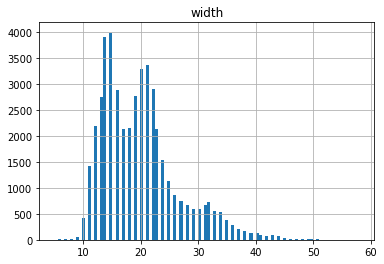

In [ ]:
detection_result.hist(bins=100, column='width')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d2781fe90>]],
      dtype=object)

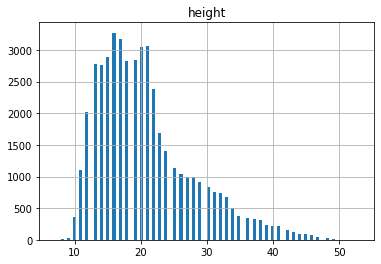

In [ ]:
detection_result.hist(bins=100, column='height')

## numbers of bbox for every frame

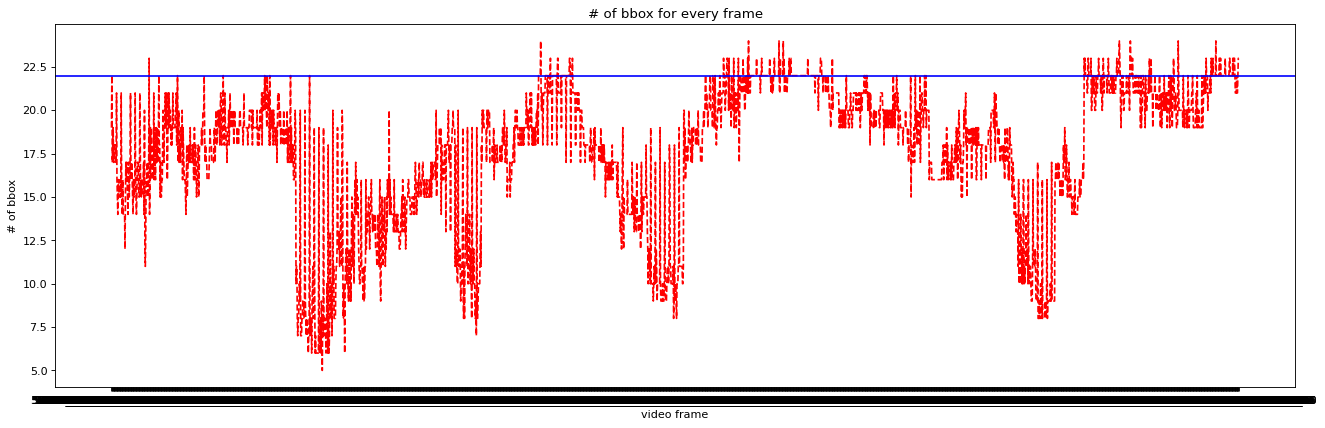

In [ ]:
import matplotlib.pyplot as plt

x = detection_result['video_frame'].unique()
y = detection_result.groupby('video_frame').agg(np.size)[['left']].to_numpy()

plt.figure(figsize=(20, 6), dpi=80)
plt.plot(x, y, 'r--')
plt.axhline(y=22, color='b', linestyle='-')
plt.title('# of bbox for every frame')
plt.xlabel('video frame')
plt.ylabel('# of bbox')
plt.show()

### try to find which frame has low detection result

In [54]:
low_bbox = detection_result.groupby('video_frame').filter(lambda x: len(x) < 10)[['video_frame']]['video_frame'].unique()
low_bbox_map = {}
for i in low_bbox:
  video_name = ('_').join(i.split('_')[:3])
  frame_no = i.split('_')[3]
  if video_name in low_bbox_map:
    low_bbox_map[video_name].append(frame_no)
  else:
    low_bbox_map[video_name] = [frame_no]

for i in low_bbox_map.keys():
  print(i, low_bbox_map[i])
  

57906_000718_Sideline ['103', '104', '105', '106', '107', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '138', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '168', '169', '170', '171', '172', '173', '175', '176', '178', '179', '182', '183', '184', '185', '200', '201', '203', '204', '212', '216', '218', '244', '246', '247', '281', '55', '60', '61', '63', '79', '86', '87', '88', '89', '90', '91', '92']
57995_000109_Endzone ['465', '473', '481', '482', '483', '484', '486', '487', '488', '491', '492', '493', '508', '509', '510', '513', '514']
58102_002798_Endzone ['316', '317', '318', '326', '327', '328', '329', '330', '331', '332', '333', '334', '335', '337', '339', '340', '341', '342', '343', '344', '345', '346', 

## baseline detection result data exploration (for comparsion)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d19818410>]],
      dtype=object)

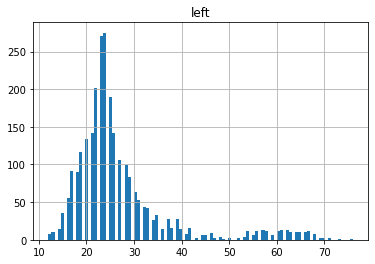

In [55]:
data = pd.read_csv('data/test_baseline_helmets.csv')
data.groupby('video_frame').agg(np.size)[['left']].hist(bins=100)


In [ ]:
print(data.max())
print(data.min())

video_frame    58102_002798_Sideline_99
left                               1277
width                                86
top                                 716
height                               96
conf                           0.905762
dtype: object
video_frame    57906_000718_Endzone_1
left                                0
width                               2
top                                 0
height                              0
conf                        0.0500183
dtype: object


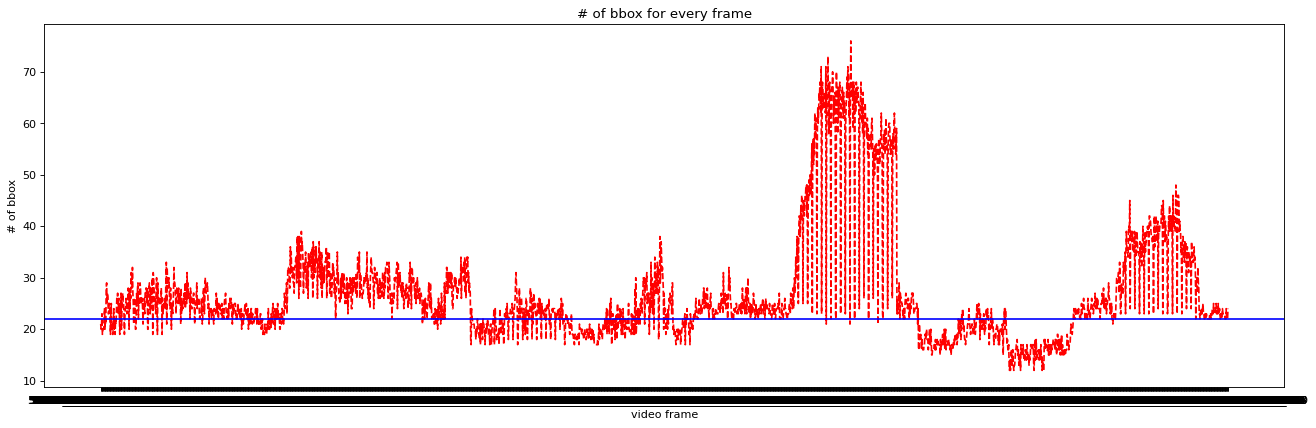

In [ ]:
import matplotlib.pyplot as plt

x = data['video_frame'].unique()
y = data.groupby('video_frame').agg(np.size)[['left']].to_numpy()

plt.figure(figsize=(20, 6), dpi=80)
plt.plot(x, y, 'r--')
plt.axhline(y=22, color='b', linestyle='-')
plt.title('# of bbox for every frame')
plt.xlabel('video frame')
plt.ylabel('# of bbox')
plt.show()